In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu

In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir    = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR','P38NR','P38DR','P28DL'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 21269 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_168827/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


Class_broad  Doublet  Doublet Score batch  \
AAACGCTCACTTCATT-1-P8_1a-P8   Excitatory    False       0.025713     1   
AAAGGATAGGTGCATG-1-P8_1a-P8   Excitatory    False       0.011883     1   
AAAGGGCCAGTATACC-1-P8_1a-P8   Excitatory    False       0.024667     1   
AAAGTCCCATATACCG-1-P8_1a-P8   Excitatory    False       0.027921     1   
AAAGTCCTCAGATGCT-1-P8_1a-P8   Excitatory    False       0.009527     1   
...                                  ...      ...            ...   ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a         NaN    False       0.042872    11   
TTTGGTTTCTGCCTGT-1-P38_dr_2b         NaN    False       0.007108     2   
TTTGTTGCACCGGTCA-1-P38_dr_2a         NaN    False       0.030928     2   
TTTGTTGGTGGCTAGA-1-P38_dr_2b         NaN    False       0.015884     3   
TTTGTTGTCTATTGTC-1-P38_dr_1a         NaN    False       0.028005     3   

                              leiden  n_counts  n_genes  percent_mito  \
AAACGCTCACTTCATT-1-P8_1a-P8        0   23384.0     4943      0.000128   
AAAGGATAGGTGCATG-1-P8_1a-P8        0   17774.0     4698      0.000169   
AAAGGGCCAGTATACC-1-P8_1a-P8        0   15872.0     4173      0.000126   
AAAGTCCCATATACCG-1-P8_1a-P8        0   20076.0     4761      0.000050   
AAAGTCCTCAGATGCT-1-P8_1a-P8        4   19061.0     4601      0.000000   
...                              ...       ...      ...           ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a       1   11379.0     3568      0.000879   
TTTGGTTTCTGCCTGT-1-P38_dr_2b       1   16050.0     3104      0.000062   
TTTGTTGCACCGGTCA-1-P38_dr_2a       1   13955.0     3739      0.001146   
TTTGTTGGTGGCTAGA-1-P38_dr_2b       4    7272.0     2789      0.000963   
TTTGTTGTCTATTGTC-1-P38_dr_1a       4   11447.0     2959      0.000262   

                                 sample     Type Subclass   cond easitype  \
AAACGCTCACTTCATT-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGATAGGTGCATG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGGGCCAGTATACC-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCCATATACCG-1-P8_1a-P8       P8_1a  L2/3_AB     L2/3   P8NR   L2/3_A   
AAAGTCCTCAGATGCT-1-P8_1a-P8       P8_1a  L2/3_BC     L2/3   P8NR   L2/3_C   
...                                 ...      ...      ...    ...      ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  P38_dr_1a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGGTTTCTGCCTGT-1-P38_dr_2b  P38_dr_2b   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGCACCGGTCA-1-P38_dr_2a  P38_dr_2a   L2/3_3     L2/3  P38DR   L2/3_C   
TTTGTTGGTGGCTAGA-1-P38_dr_2b  P38_dr_2b   L2/3_2     L2/3  P38DR   L2/3_B   
TTTGTTGTCTATTGTC-1-P38_dr_1a  P38_dr_1a   L2/3_2     L2/3  P38DR   L2/3_B   

                              umap1  umap2 easisample easicond newtype  
AAACGCTCACTTCATT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGATAGGTGCATG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGGGCCAGTATACC-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCCATATACCG-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_A  
AAAGTCCTCAGATGCT-1-P8_1a-P8     NaN    NaN         1a  1-P08NR  L2/3_C  
...                             ...    ...        ...      ...     ...  
TTTGGTTCAGTTGTTG-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  
TTTGGTTTCTGCCTGT-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_B  
TTTGTTGCACCGGTCA-1-P38_dr_2a    NaN    NaN         2a  2-P38DR  L2/3_B  
TTTGTTGGTGGCTAGA-1-P38_dr_2b    NaN    NaN         2b  2-P38DR  L2/3_A  
TTTGTTGTCTATTGTC-1-P38_dr_1a    NaN    NaN         1a  2-P38DR  L2/3_B  

[41048 rows x 18 columns]

In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_168827/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [10]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [11]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [12]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

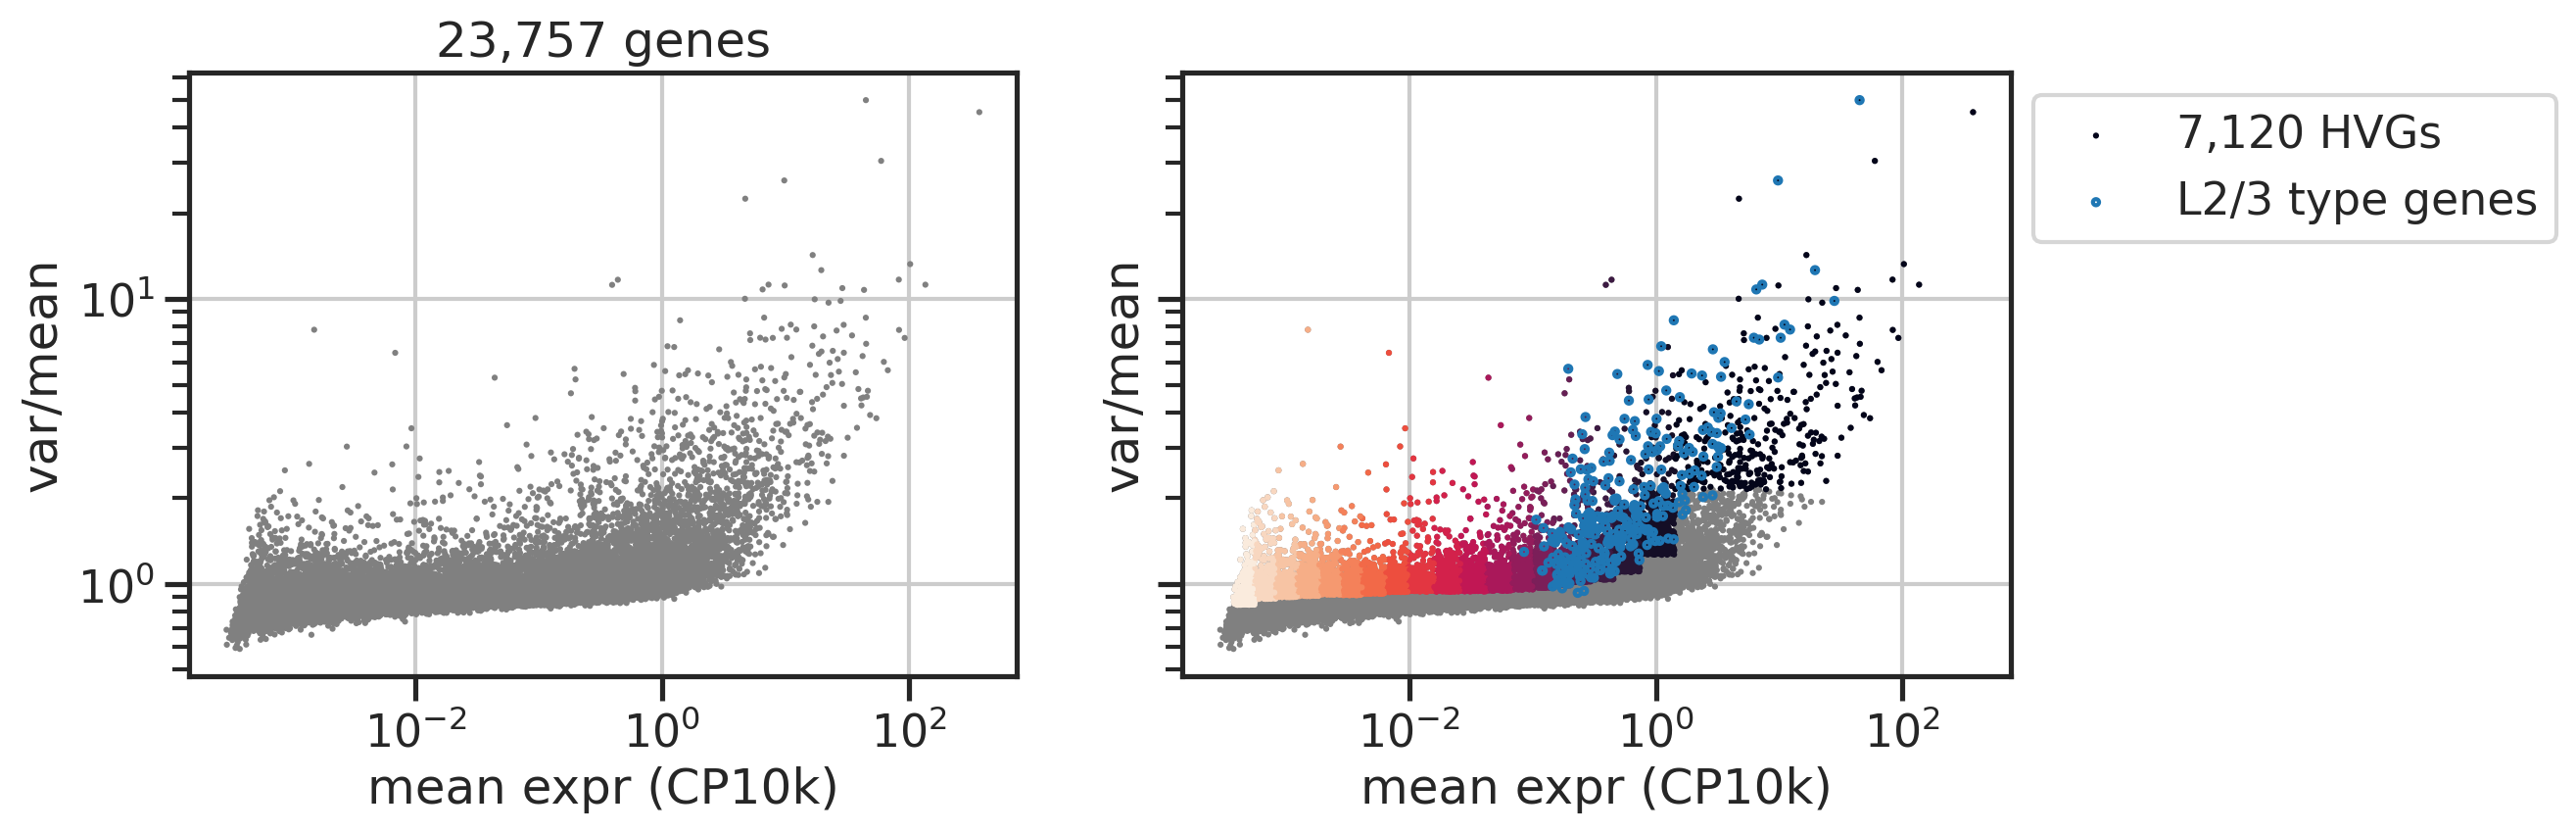

In [13]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [14]:
# adata = adata_sub[:,gsel_idx]
adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 21269 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [15]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=4)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering

In [16]:
np.random.seed(0)

X, pca, pcs = pca_pipe(adata)
V = pca.components_.T
V[:,1] = -V[:,1]
pcs[:,1] = -pcs[:,1]

In [17]:
adata.obsm['pcs'] = pcs

In [18]:
adata_nr28 = adata[adata.obs['cond']=='P28NR']
adata_nr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_1' in x)]
adata_nr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_2' in x)]

adata_dr28 = adata[adata.obs['cond']=='P28DR']
adata_dr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_1' in x)]
adata_dr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_3' in x)]



adata_nr38 = adata[adata.obs['cond']=='P38NR']
adata_nr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_1' in x)]
adata_nr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_2' in x)]

adata_dr38 = adata[adata.obs['cond']=='P38DR']
adata_dr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_1' in x)]
adata_dr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_2' in x)]

adata_dl28 = adata[adata.obs['cond']=='P28DL']
adata_dl28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_dl_1' in x)]
adata_dl28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_dl_2' in x)]

In [19]:
def organize_pc_res(adata, pcs):
    """
    """
    df = adata.obs.join(pd.DataFrame(pcs, 
                                     index=adata.obs.index, 
                                     columns=np.char.add("PC", (1+np.arange(pcs.shape[1])).astype(str))))
    return df

In [20]:
df_nr28_1 = organize_pc_res(adata_nr28_1, adata_nr28_1.obsm['pcs'])
df_nr28_2 = organize_pc_res(adata_nr28_2, adata_nr28_2.obsm['pcs'])

df_dr28_1 = organize_pc_res(adata_dr28_1, adata_dr28_1.obsm['pcs'])
df_dr28_2 = organize_pc_res(adata_dr28_2, adata_dr28_2.obsm['pcs'])

df_dl28_1 = organize_pc_res(adata_dl28_1, adata_dl28_1.obsm['pcs'])
df_dl28_2 = organize_pc_res(adata_dl28_2, adata_dl28_2.obsm['pcs'])

df_nr38_1 = organize_pc_res(adata_nr38_1, adata_nr38_1.obsm['pcs'])
df_nr38_2 = organize_pc_res(adata_nr38_2, adata_nr38_2.obsm['pcs'])

df_dr38_1 = organize_pc_res(adata_dr38_1, adata_dr38_1.obsm['pcs'])
df_dr38_2 = organize_pc_res(adata_dr38_2, adata_dr38_2.obsm['pcs'])


In [21]:
prj_nr28_1 = adata_nr28_1.obsm['pcs'][:,:2]
prj_nr28_2 = adata_nr28_2.obsm['pcs'][:,:2]

prj_dr28_1 = adata_dr28_1.obsm['pcs'][:,:2]
prj_dr28_2 = adata_dr28_2.obsm['pcs'][:,:2]

prj_dl28_1 = adata_dl28_1.obsm['pcs'][:,:2]
prj_dl28_2 = adata_dl28_2.obsm['pcs'][:,:2]

prj_nr38_1 = adata_nr38_1.obsm['pcs'][:,:2]
prj_nr38_2 = adata_nr38_2.obsm['pcs'][:,:2]

prj_dr38_1 = adata_dr38_1.obsm['pcs'][:,:2]
prj_dr38_2 = adata_dr38_2.obsm['pcs'][:,:2]

# prj_nr = adata_nr.obsm['pcs'][:,:2]
# prj_dr = adata_dr.obsm['pcs'][:,:2]

In [22]:
labels = [
    'P28NR_1', 'P28NR_2',
    'P28DR_1', 'P28DR_2',
    'P28DL_1', 'P28DL_2',
    'P38NR_1', 'P38NR_2',
    'P38DR_1', 'P38DR_2',
    ]


prjs = [
    prj_nr28_1, prj_nr28_2,
    prj_dr28_1, prj_dr28_2,
    prj_dl28_1, prj_dl28_2,
    prj_nr38_1, prj_nr38_2,
    prj_dr38_1, prj_dr38_2,
]
dfs = [
    df_nr28_1, df_nr28_2,
    df_dr28_1, df_dr28_2,
    df_dl28_1, df_dl28_2,
    df_nr38_1, df_nr38_2,
    df_dr38_1, df_dr38_2,
]


In [23]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_scatter_2023-11-20.pdf


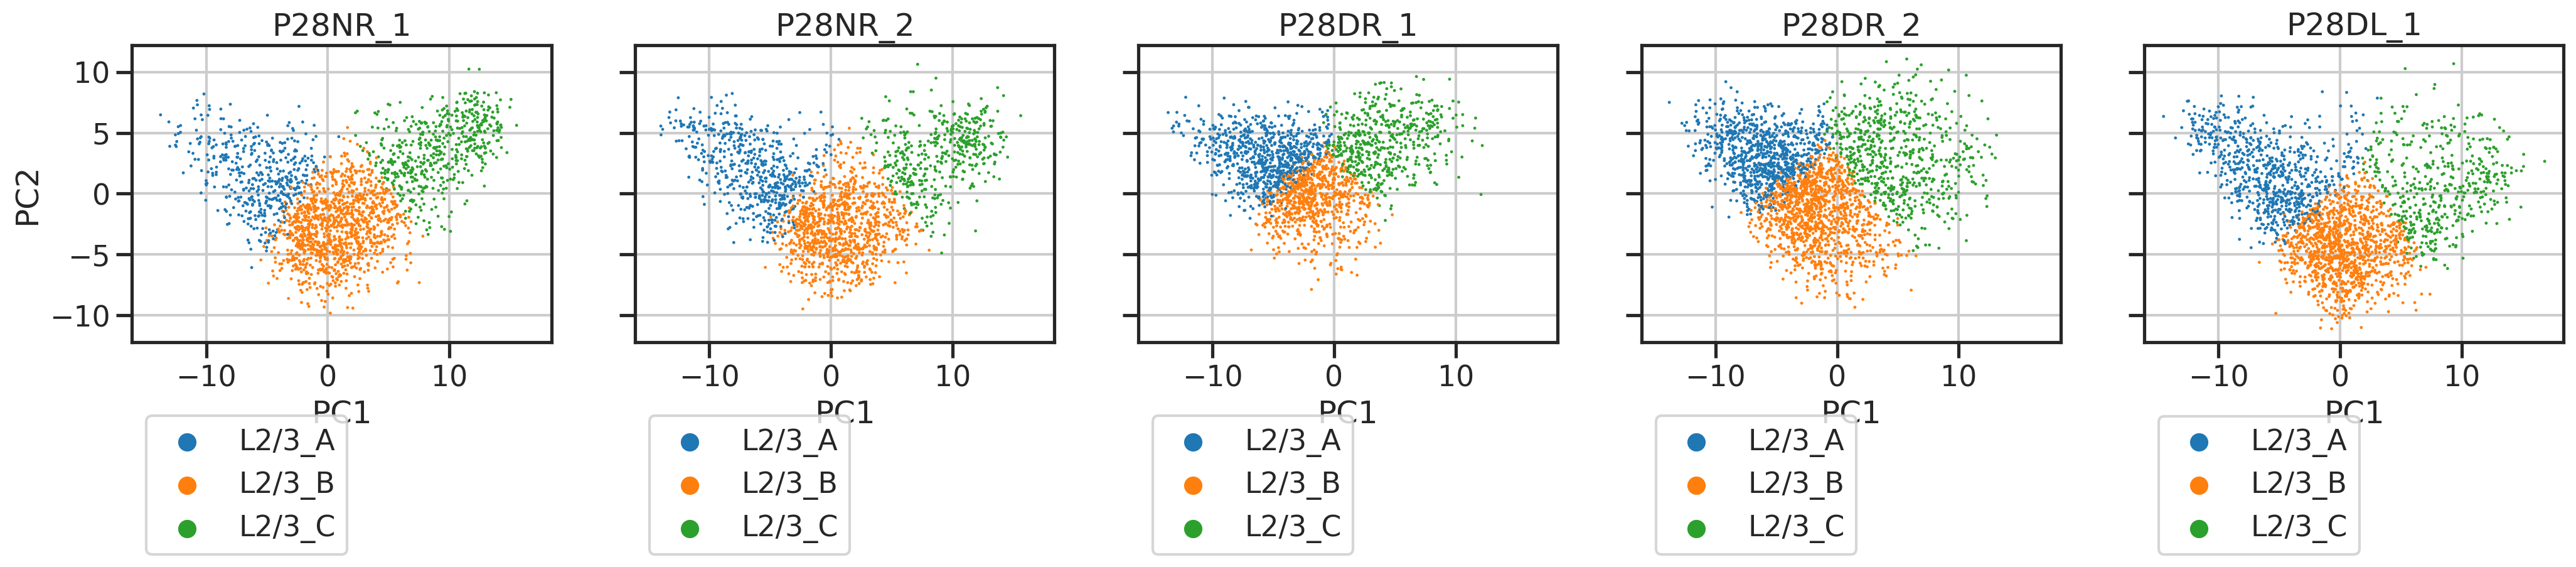

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

output = os.path.join(outfigdir, 'grad_scatter.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_scatter2_2023-11-20.pdf


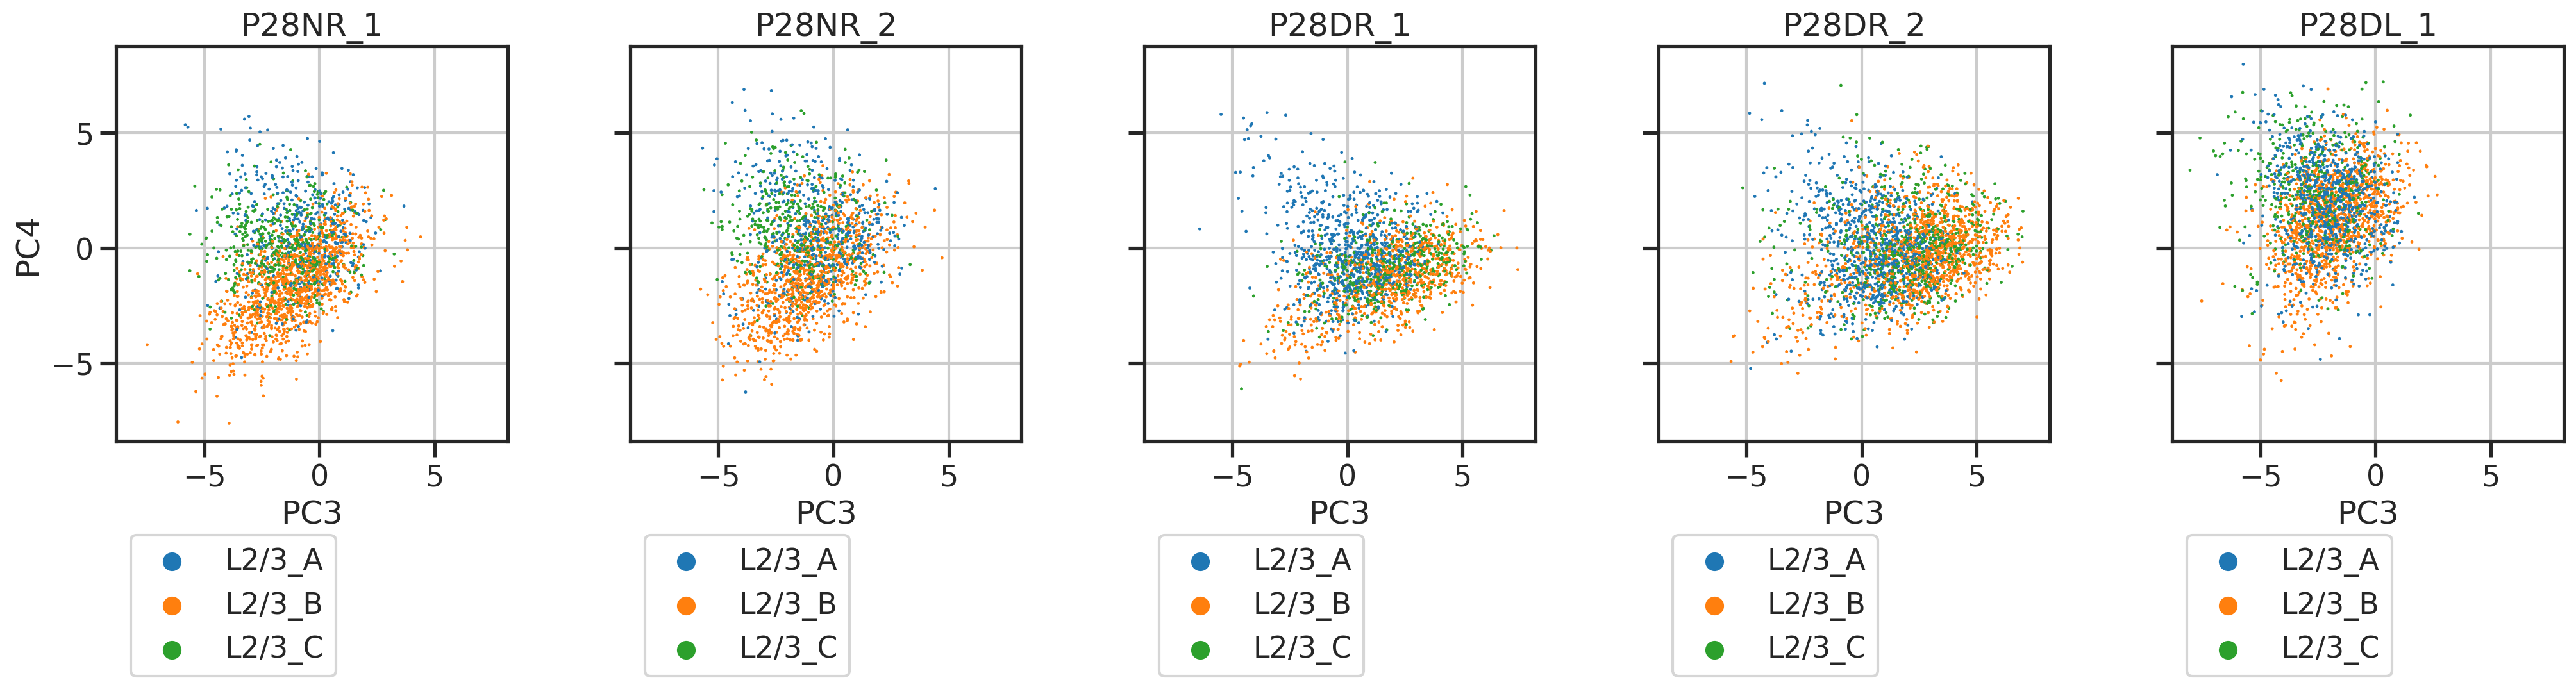

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.scatterplot(data=df, x='PC3', y='PC4', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')

output = os.path.join(outfigdir, 'grad_scatter2.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_heatmap_2023-11-20.pdf


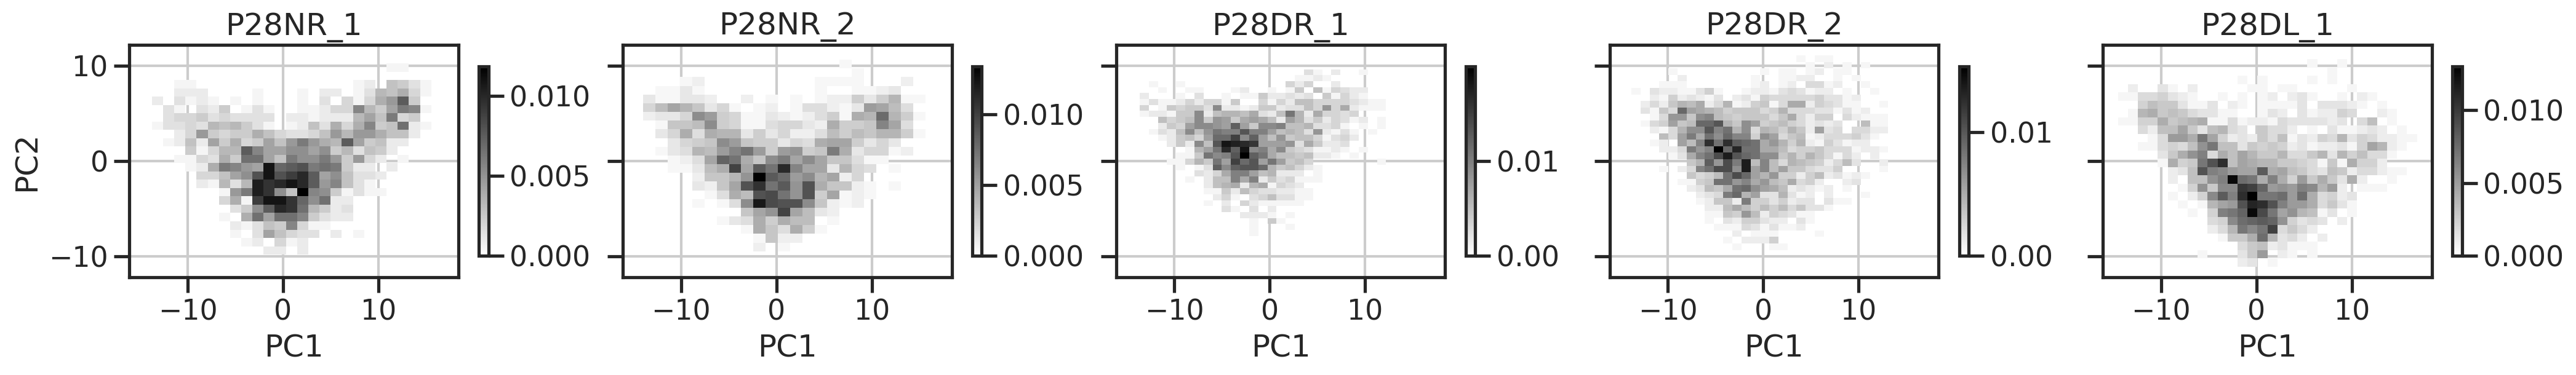

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    sns.histplot(ax=ax, data=df, stat='density', x='PC1', y='PC2', cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    # ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
output = os.path.join(outfigdir, 'grad_heatmap.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# Archetype

In [27]:
from py_pcha import PCHA

In [28]:
def get_dists_to_specialists(prj, XC):
    """
    """
    diffs = np.array([prj-XC[:,0], prj-XC[:,1], prj-XC[:,2]]) # specialist by cell by dim
    dists = np.sqrt(np.sum(np.power(diffs, 2), axis=2)) # specialist by cell
    # print(diffs.shape, dists.shape)
    return dists

In [29]:
np.random.seed(0)
XC_dict = {}
for lbl, prj in zip(labels, prjs): 
    X = prj.T
    XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])].copy() # order this
    print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape, SSE, varexpl)
    XC_dict[lbl] = XC

(2, 3) (3, 2071) (2071, 3) () () 262.16491228451196 0.9974613779012049
(2, 3) (3, 1973) (1973, 3) () () 316.6668485035334 0.9968136032381383
(2, 3) (3, 2011) (2011, 3) () () 194.395305812679 0.9973380733275611
(2, 3) (3, 2693) (2693, 3) () () 729.9698228714988 0.9931625232146433
(2, 3) (3, 2367) (2367, 3) () () 457.994855747369 0.9961039899238744
(2, 3) (3, 2292) (2292, 3) () () 603.0717926198558 0.9954606794024656
(2, 3) (3, 720) (720, 3) () () 72.09194617191679 0.9976120989213018
(2, 3) (3, 1977) (1977, 3) () () 117.24135035790096 0.9984267264830977
(2, 3) (3, 2426) (2426, 3) () () 815.637717949081 0.9918970302537601
(2, 3) (3, 2739) (2739, 3) () () 450.24228920902533 0.995793943105833


In [30]:
dists_dict = {}
for lbl, prj in zip(labels, prjs): 
    XC  = XC_dict[lbl]
    dists = get_dists_to_specialists(prj, XC)
    dists_dict[lbl] = dists

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_2023-11-20.pdf


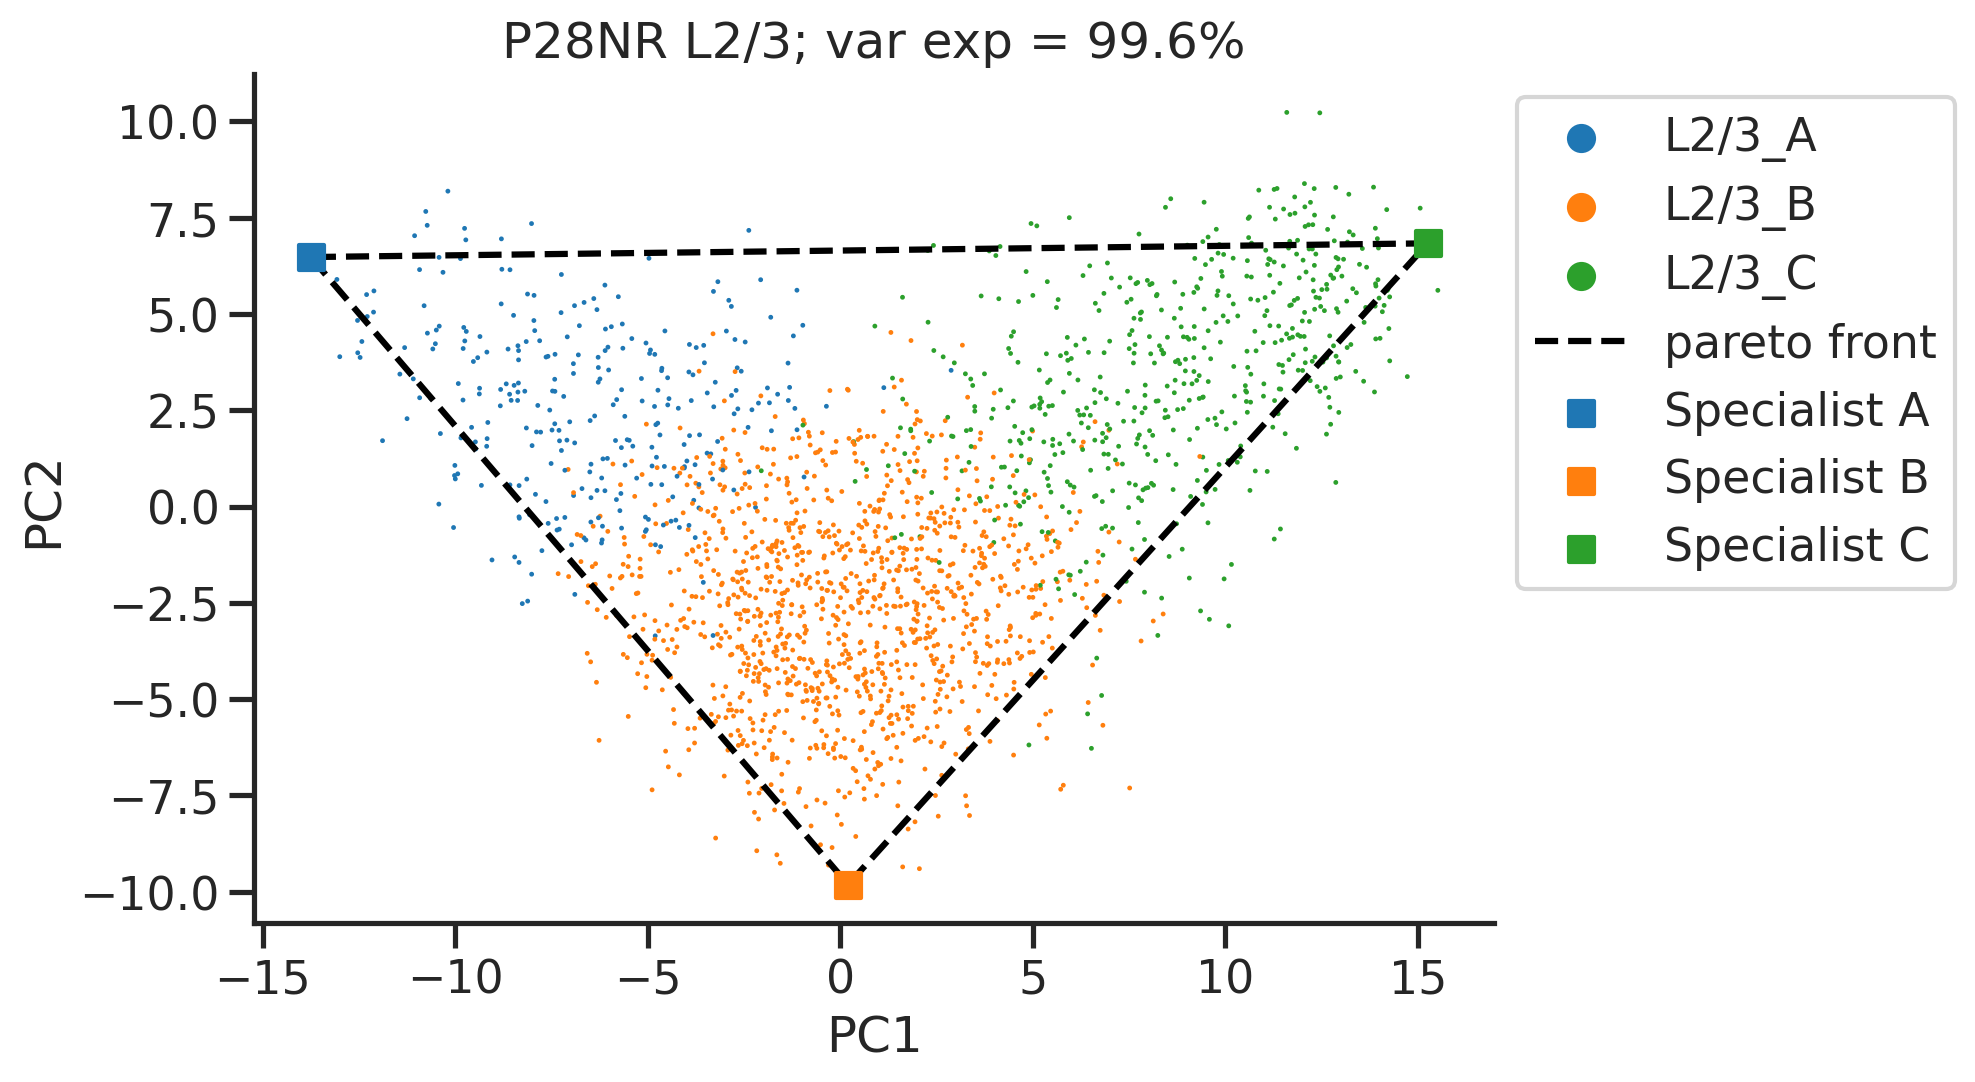

In [31]:
XC = XC_dict['P28NR_1']
df = df_nr28_1

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='easitype', s=3, palette=palette_type, hue_order=list(palette_type), edgecolor='none', ax=ax)
ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='pareto front', zorder=1)
ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
ax.legend(bbox_to_anchor=(1,1))
ax.set_aspect('equal')
ax.set_title(f'P28NR L2/3; var exp = {100*varexpl:.1f}%')
output = os.path.join(outfigdir, 'grad_archetype.pdf')
powerplots.savefig_autodate(fig, output)
sns.despine(ax=ax)
ax.grid(False)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_2_2023-11-20.pdf


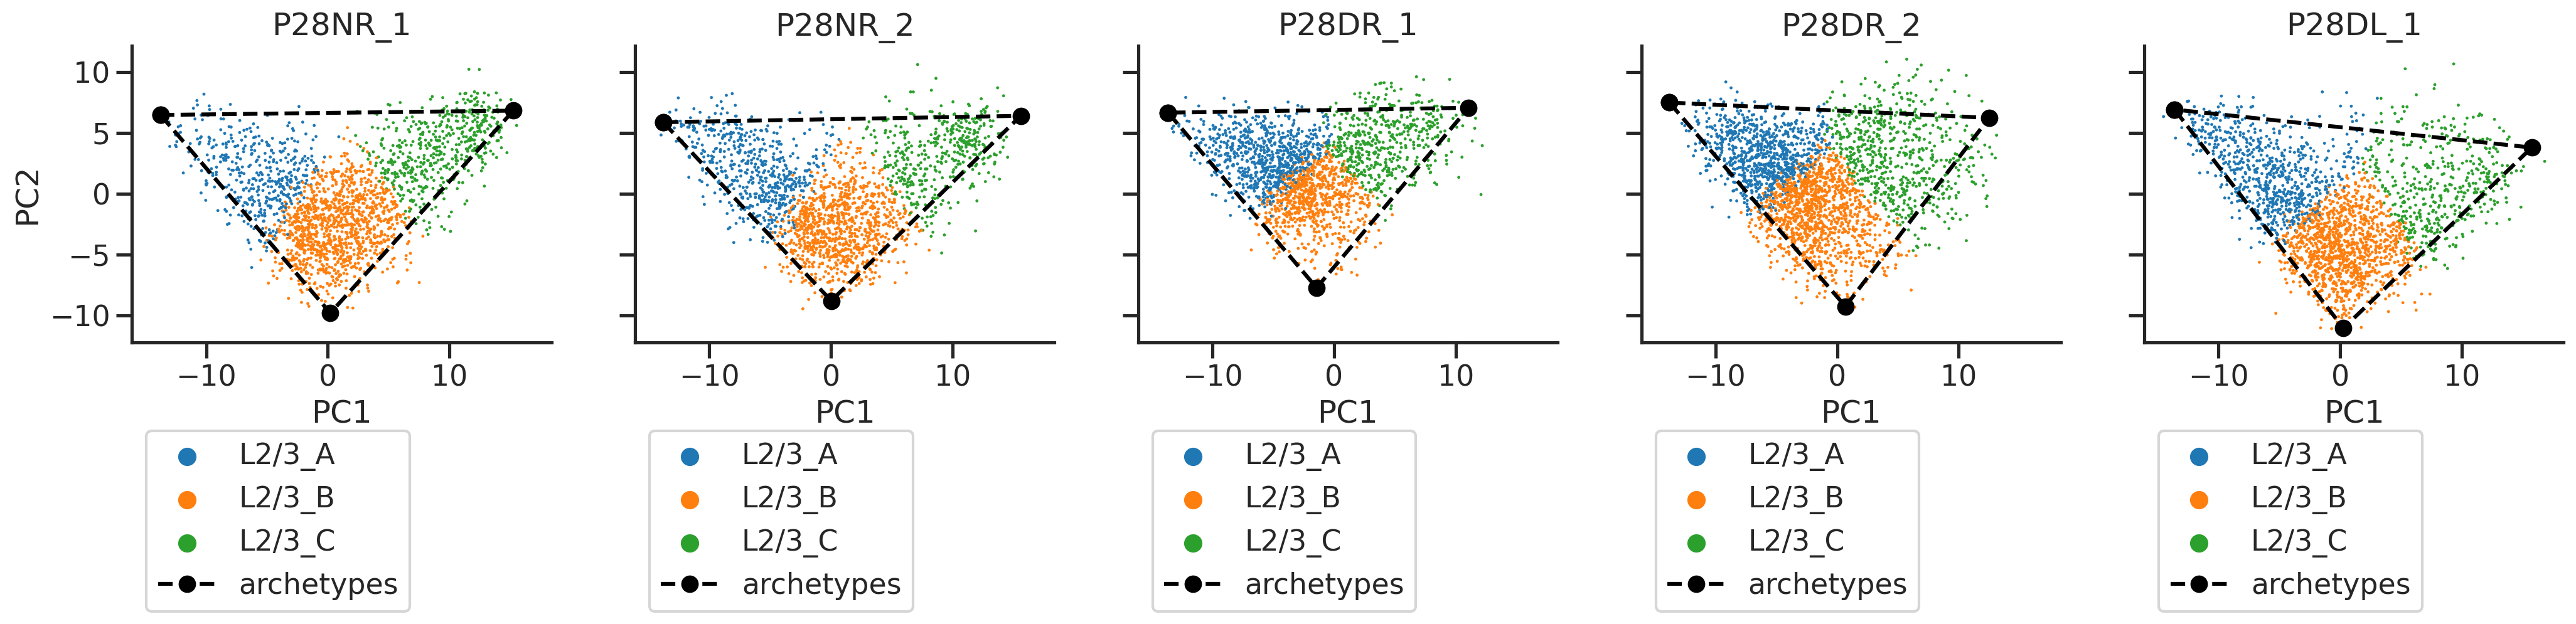

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs, dfs, labels):
    XC = XC_dict[lbl]
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetypes')
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)

output = os.path.join(outfigdir, 'grad_archetype_2.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/grad_archetype_4_2023-11-20.pdf


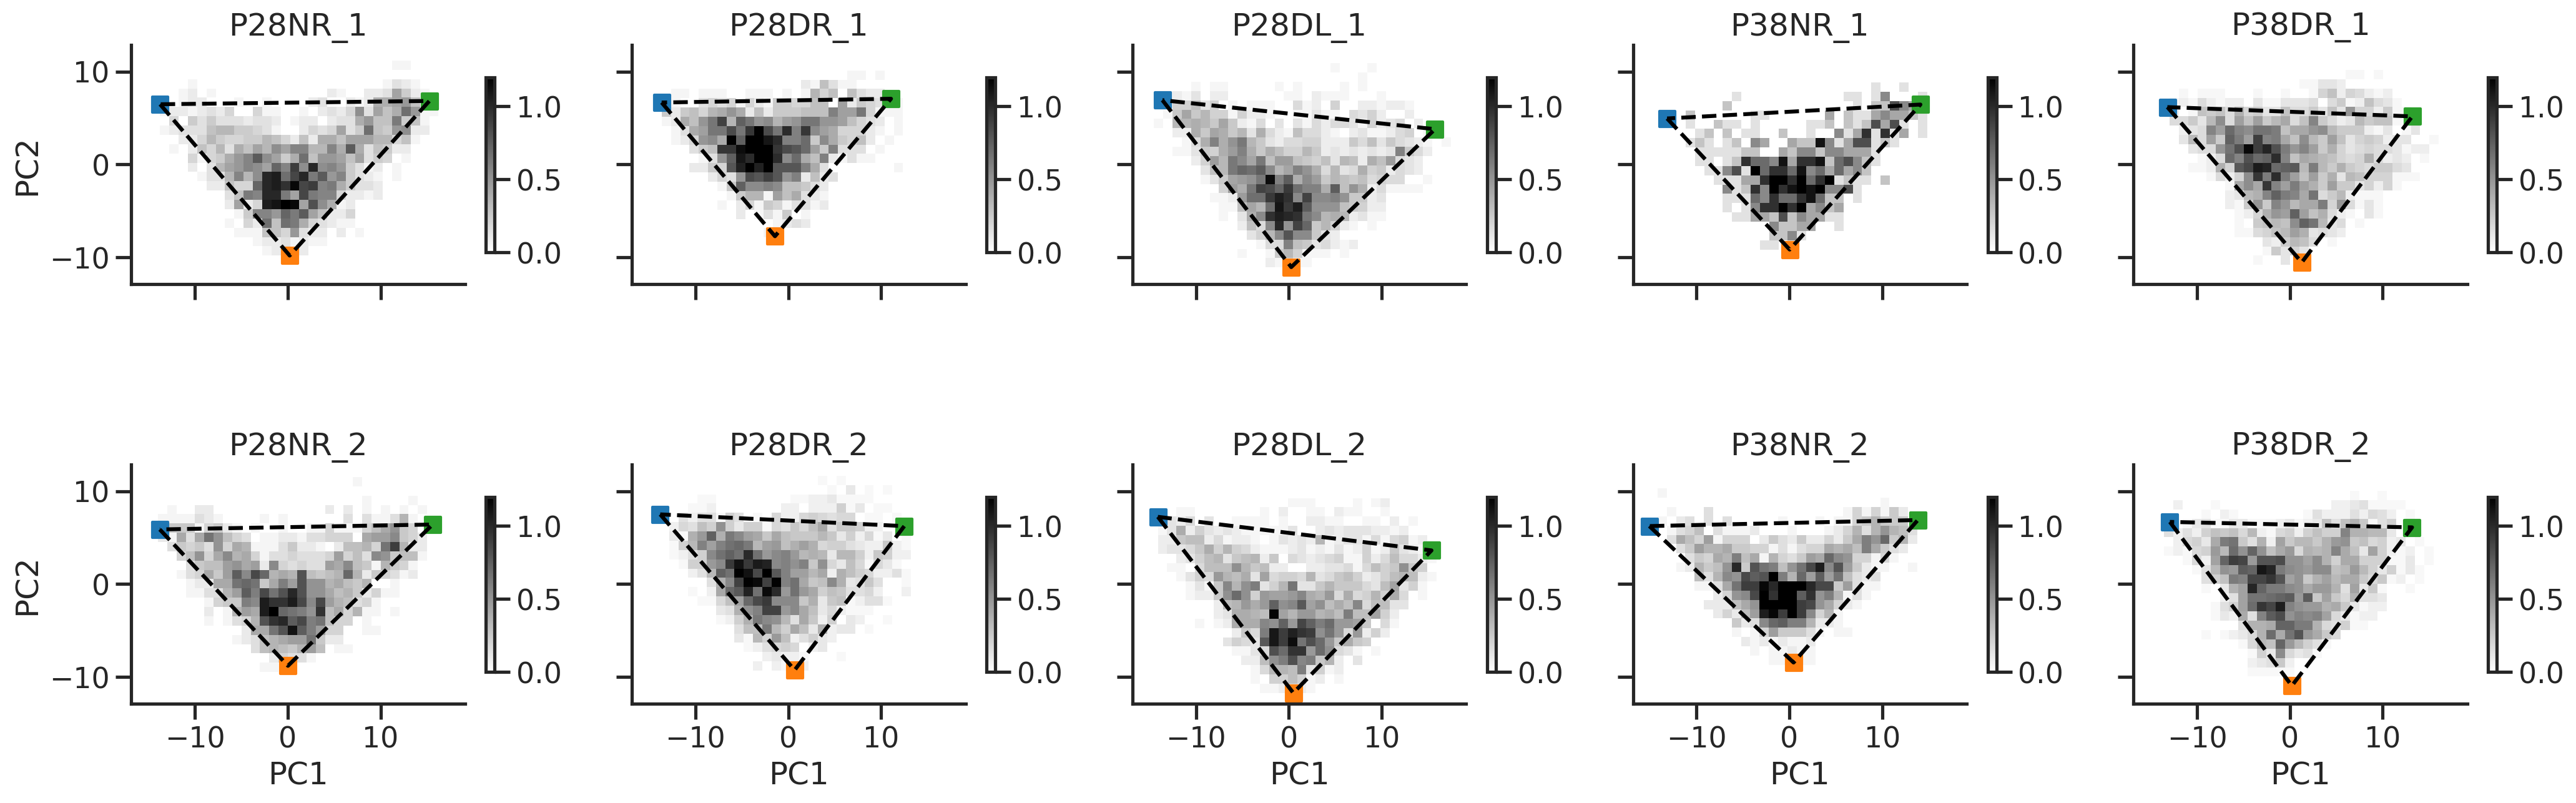

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(5*5,2*4), sharex=True, sharey=True)
for ax, df, lbl in zip(axs.flat, dfs[::2]+dfs[1::2], labels[::2]+labels[1::2]):
    XC = XC_dict[lbl]
    g = sns.histplot(ax=ax, data=df, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--k', label='archetypes')
    ax.scatter(XC[0,[0]], XC[1,[0]], color='C0', marker='s', label='Specialist A')
    ax.scatter(XC[0,[1]], XC[1,[1]], color='C1', marker='s', label='Specialist B')
    ax.scatter(XC[0,[2]], XC[1,[2]], color='C2', marker='s', label='Specialist C')
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl)
    ax.set_aspect('equal')
    
output = os.path.join(outfigdir, 'grad_archetype_4.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# quantify A, B, C closeness

In [34]:
res_frac = pd.DataFrame(index=['A pole', 'B pole', 'C pole'])

for lbl in labels:
    unqs, cnts = np.unique(np.argmin(dists_dict[lbl], axis=0), return_counts=True)
    print(unqs, cnts/cnts.sum())
    res_frac[lbl] = cnts/cnts.sum()

[0 1 2] [0.14147755 0.61419604 0.24432641]
[0 1 2] [0.1926001  0.60263558 0.20476432]
[0 1 2] [0.26553953 0.50671308 0.22774739]
[0 1 2] [0.31006313 0.48236168 0.20757519]
[0 1 2] [0.21968737 0.61554711 0.16476553]
[0 1 2] [0.18150087 0.60471204 0.21378709]
[0 1 2] [0.10555556 0.6375     0.25694444]
[0 1 2] [0.15073343 0.6616085  0.18765807]
[0 1 2] [0.30873866 0.44765045 0.24361088]
[0 1 2] [0.28952172 0.43556042 0.27491785]


In [35]:
res_frac

P28NR_1   P28NR_2   P28DR_1   P28DR_2   P28DL_1   P28DL_2   P38NR_1  \
A pole  0.141478  0.192600  0.265540  0.310063  0.219687  0.181501  0.105556   
B pole  0.614196  0.602636  0.506713  0.482362  0.615547  0.604712  0.637500   
C pole  0.244326  0.204764  0.227747  0.207575  0.164766  0.213787  0.256944   

         P38NR_2   P38DR_1   P38DR_2  
A pole  0.150733  0.308739  0.289522  
B pole  0.661608  0.447650  0.435560  
C pole  0.187658  0.243611  0.274918

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/bar_frac_abc_pole_2023-11-19.pdf


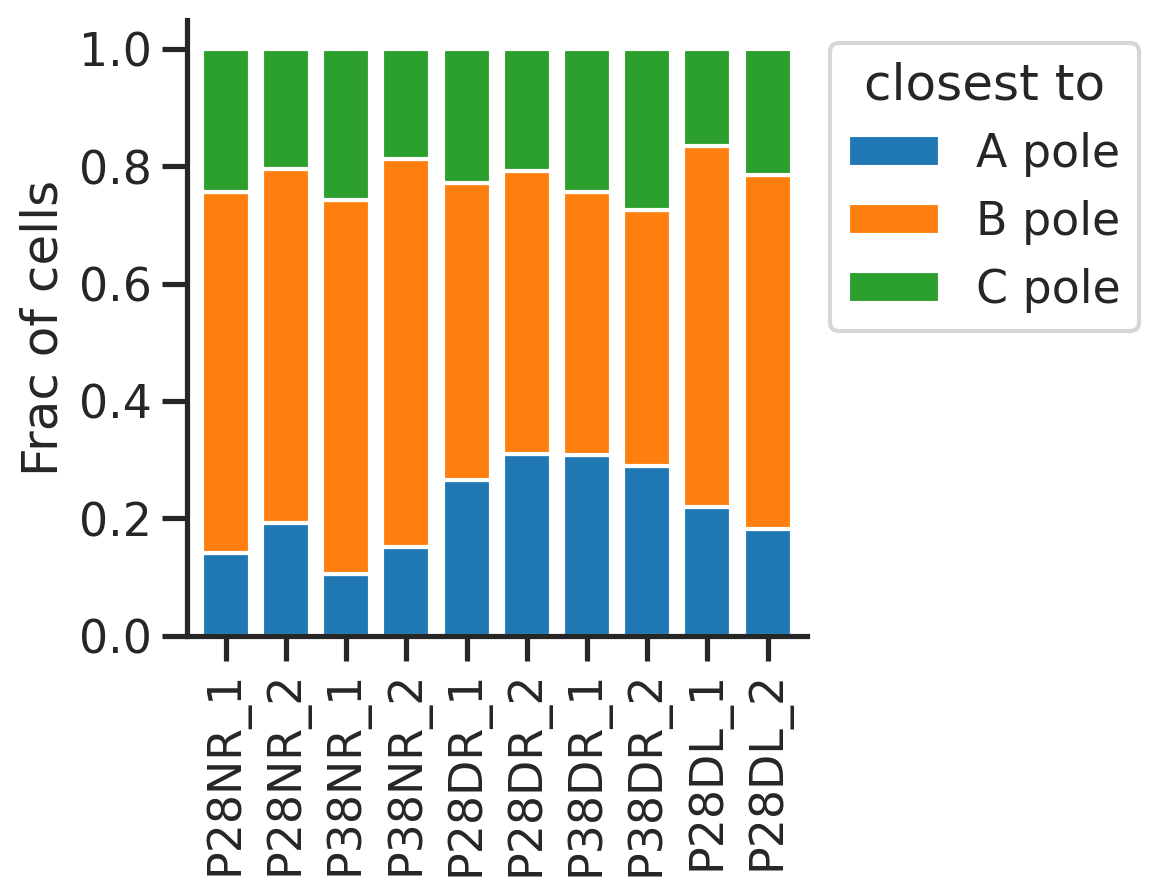

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
res_frac[['P28NR_1', 'P28NR_2',
          'P38NR_1', 'P38NR_2',
          'P28DR_1', 'P28DR_2',
          'P38DR_1', 'P38DR_2',
          'P28DL_1', 'P28DL_2',
         ]].T.plot.bar(
    ax=ax, stacked=True, width=0.8,  
)
ax.legend(bbox_to_anchor=(1,1), title='closest to')
sns.despine(ax=ax)
ax.set_ylabel('Frac of cells')
ax.grid(False)
output = os.path.join(outfigdir, 'bar_frac_abc_pole.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()


In [37]:
dfbox = res_frac.stack().reset_index()
dfbox['cond'] = dfbox['level_1'].apply(lambda x: x[3:5])
dfbox

level_0  level_1         0 cond
0   A pole  P28NR_1  0.141478   NR
1   A pole  P28NR_2  0.192600   NR
2   A pole  P28DR_1  0.265540   DR
3   A pole  P28DR_2  0.310063   DR
4   A pole  P28DL_1  0.219687   DL
5   A pole  P28DL_2  0.181501   DL
6   A pole  P38NR_1  0.105556   NR
7   A pole  P38NR_2  0.150733   NR
8   A pole  P38DR_1  0.308739   DR
9   A pole  P38DR_2  0.289522   DR
10  B pole  P28NR_1  0.614196   NR
11  B pole  P28NR_2  0.602636   NR
12  B pole  P28DR_1  0.506713   DR
13  B pole  P28DR_2  0.482362   DR
14  B pole  P28DL_1  0.615547   DL
15  B pole  P28DL_2  0.604712   DL
16  B pole  P38NR_1  0.637500   NR
17  B pole  P38NR_2  0.661608   NR
18  B pole  P38DR_1  0.447650   DR
19  B pole  P38DR_2  0.435560   DR
20  C pole  P28NR_1  0.244326   NR
21  C pole  P28NR_2  0.204764   NR
22  C pole  P28DR_1  0.227747   DR
23  C pole  P28DR_2  0.207575   DR
24  C pole  P28DL_1  0.164766   DL
25  C pole  P28DL_2  0.213787   DL
26  C pole  P38NR_1  0.256944   NR
27  C pole  P38NR_2  0.187658   NR
28  C pole  P38DR_1  0.243611   DR
29  C pole  P38DR_2  0.274918   DR

In [38]:
from scipy.stats import mannwhitneyu

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/box_abc_poles_2023-11-19.pdf


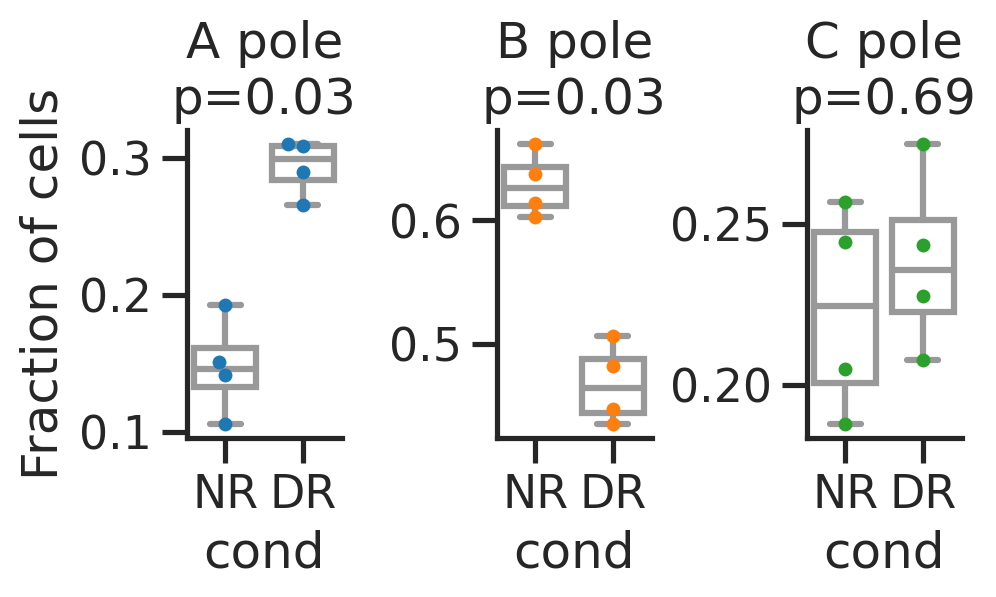

In [40]:
fig, axs = plt.subplots(1,3, figsize=(5,2))
ax = axs[0]
for ax, _type, color in zip(axs, ['A pole', 'B pole', 'C pole'], ['C0', 'C1', 'C2']):
    dfboxsub = dfbox[(dfbox['cond'].isin(['NR', 'DR'])) & (dfbox['level_0']==_type)]
    a = dfboxsub.loc[dfboxsub['cond']=='NR', 0]
    b = dfboxsub.loc[dfboxsub['cond']=='DR', 0]
    s, p = mannwhitneyu(a, b, use_continuity=True, alternative='two-sided', axis=0, method='auto',)
    sns.boxplot(data=dfboxsub, x='cond', y=0, color='white', ax=ax)
    sns.swarmplot(data=dfboxsub, x='cond', y=0, ax=ax, color=color)
    ax.grid(False)
    ax.set_title(f'{_type}\np={p:.2f}')
    ax.set_ylabel('')
    sns.despine(ax=ax)
    
axs[0].set_ylabel('Fraction of cells')
fig.subplots_adjust(wspace=1)
output = os.path.join(outfigdir, "box_abc_poles.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()